# Convolutional Auto-Encoder

In [1]:
# Imports
#!pip install mxnet
from convvae import ConvVae
import numpy as np
import PIL
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
from sklearn.model_selection import train_test_split
# !pip install tqdm
from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
import Neurosmash

# These are the default environment arguments. They must be the same as the values that are set in the environment GUI.
ip         = "127.0.0.1" # Ip address that the TCP/IP interface listens to (127.0.0.1 by default)
port       = 13000       # Port number that the TCP/IP interface listens to (13000 by default)

# This is the size of the texture that the environment is rendered.
# This is set to 784 by default, which will result in a crisp image but slow speed.
# You can change the size to a value that works well for your environment but should not go too low.
size       = 64 # 96, 192

# This is the simulation speed of the environment. This is set to 1 by default.
# Setting it to n will make the simulation n times faster.
# In other words, less (if n < 1) or more (if n > 1) simulation time will pass per step.
# You might want to increase this value to around 10 if you cannot train your models fast enough
# so that they can sample more states in a shorter number of steps at the expense of precision.
timescale  = 5

# This is an example agent.
# It has a step function, which gets reward/state as arguments and returns an action.
# Right now, it always outputs a random action (3) regardless of reward/state.
# The real agent should output one of the following three actions:
# none (0), left (1) and right (2)
agent = Neurosmash.Agent() 

# This is the main environment.
# It has a reset function, which is used to reset the environment before episodes.
# It also has a step function, which is used to which steps one time point
# It gets an action (as defined above) as input and outputs the following:
# end (true if the episode has ended, false otherwise)
# reward (10 if won, 0 otherwise)
# state (flattened size x size x 3 vector of pixel values)
# The state can be converted into an image as follows:
# image = np.array(state, "uint8").reshape(size, size, 3)
# You can also use to Neurosmash.Environment.state2image(state) function which returns
# the state as a PIL image
environment = Neurosmash.Environment(ip, port, size, timescale)



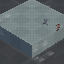

In [3]:
# The following steps through an entire episode from start to finish with random actions (by default)

end, reward, state = environment.reset()
nr_images = 500
shape = np.array(state).reshape((3, size,size)).shape
images = np.zeros((nr_images, shape[0], shape[1], shape[2]))

i = 0
while i < nr_images:
    end, reward, state = environment.reset()
    while (end == 0):
        action = agent.step(end, reward, state)
        end, reward, state = environment.step(action)
        images[i] = np.array(state).reshape(shape).astype(np.uint8)
        i += 1
        if i >= nr_images:
            end = 1

    # Let's run it a few more steps so that the things have time to settle down
    for _ in range(100):
        if i >= nr_images:
            continue
        action = agent.step(end, reward, state)
        end, reward, state = environment.step(action)
        images[i] = np.array(state).reshape(shape)
        i += 1

environment.state2image(state)


In [4]:
new_images = np.interp(images, [0,255], [0.0,1.0])

In [5]:
# n_samples = 10
# idx = np.random.choice(len(images), n_samples)
# _, axarr = plt.subplots(1, n_samples, figsize=(16,4))
# for i, j in enumerate(idx):
#     axarr[i].imshow(images[j].reshape(shape[1], shape[2], shape[0]).astype(np.uint8))
#     axarr[i].get_xaxis().set_ticks([])
#     axarr[i].get_yaxis().set_ticks([])
# plt.show()

In [22]:
batch_size = 100
train_data, test_data = train_test_split(new_images, test_size=0.33, random_state=42)

train_iter = mx.io.NDArrayIter(data={'data': train_data}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': test_data}, batch_size = batch_size)

vae = ConvVae(batch_size=batch_size, size=size)
#vae.initialize(ctx=vae.ctx) # Initialising weights
vae.collect_params().initialize(mx.init.Xavier(), ctx=vae.ctx)
# vae.hybridize()  # activates hybrid-mode of the Hybrid-Block
trainer = gluon.Trainer(vae.collect_params(), 'adam', {'learning_rate': .005}) 

In [19]:
outputs = np.zeros((1, *shape))
def train_vae(n_epochs=50, print_period=10):
    training_loss = []
    validation_loss = []

    for epoch in tqdm_notebook(range(n_epochs), desc='epochs'):
        
        #
        epoch_loss = 0
        train_iter.reset()
        test_iter.reset()

        # Training data
        n_batch_train = 0
        for batch in train_iter:
            n_batch_train += 1
            data = batch.data[0].as_in_context(vae.ctx)
            with autograd.record():
                _, loss = vae(data)
            loss.backward()
            trainer.step(data.shape[0])
            epoch_loss += nd.mean(loss).asscalar()

        # Validation data
        n_batch_val = 0
        epoch_val_loss = 0
        for batch in test_iter:
            n_batch_val += 1
            data = batch.data[0].as_in_context(vae.ctx)
            out, loss = vae(data)
            epoch_val_loss += nd.mean(loss).asscalar()
#             np.append(outputs, out.asnumpy())
            outputs = out.asnumpy()

        epoch_loss /= n_batch_train
        epoch_val_loss /= n_batch_val

        training_loss.append(epoch_loss)
        validation_loss.append(epoch_val_loss)

        if epoch % max(print_period,1) == 0:
            tqdm.write('Epoch{}, Training loss {:.2f}, Validation loss {:.2f}'.format(epoch, epoch_loss, epoch_val_loss))
    print("done.")
        
    return training_loss, validation_loss

In [8]:
train_vae(1)

appendo
appendo
Epoch0, Training loss 8514.37, Validation loss 8504.08

done.


Epoch0, Training loss 8363.37, Validation loss 13048.42
Epoch1, Training loss 9548.43, Validation loss 8469.56
Epoch2, Training loss 8468.41, Validation loss 8451.62
Epoch3, Training loss 8429.73, Validation loss 8375.59
Epoch4, Training loss 8332.30, Validation loss 8242.24
Epoch5, Training loss 8213.16, Validation loss 8178.27
Epoch6, Training loss 8158.18, Validation loss 8126.81
Epoch7, Training loss 8109.69, Validation loss 8077.26
Epoch8, Training loss 8063.17, Validation loss 8038.67
Epoch9, Training loss 8027.29, Validation loss 8014.24
Epoch10, Training loss 8004.87, Validation loss 7994.14
Epoch11, Training loss 7987.79, Validation loss 7980.38
Epoch12, Training loss 7974.41, Validation loss 7968.20
Epoch13, Training loss 7964.28, Validation loss 7957.49
Epoch14, Training loss 7954.89, Validation loss 7949.34
Epoch15, Training loss 7947.25, Validation loss 7943.17
Epoch16, Training loss 7940.67, Validation loss 7937.86
Epoch17, Training loss 7934.88, Validation loss 7931.72
E

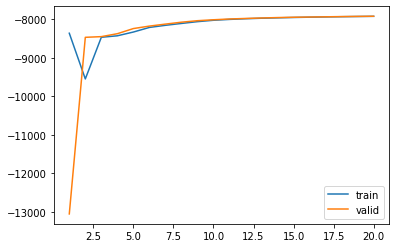

In [23]:
n_epochs = 20
training_loss, validation_loss = train_vae(n_epochs, print_period=1)
batch_x = np.linspace(1, n_epochs, len(training_loss))
plt.plot(batch_x, -1*np.array(training_loss))
plt.plot(batch_x, -1*np.array(validation_loss))
plt.legend(['train', 'valid'])

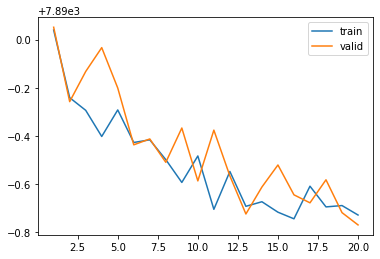

In [21]:
plt.plot(batch_x, np.array(training_loss))
plt.plot(batch_x, np.array(validation_loss))
plt.legend(['train', 'valid'])

(1, 3, 64, 64)
float64
0.0


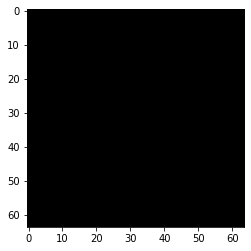

In [24]:

# out, _ = vae(mx.nd.array(images[0:100].reshape((-1, *shape))))
# print(out.shape)
# print(out.dtype)
# out_r = mx.nd.reshape(out[2], (1,2,0))
# print(out_r.shape)
# # print(out_r)
# print(out_r.dtype)
# print(len(outputs[0]))
outs = np.asarray(outputs)
print(outs.shape)
print(outs.dtype)
outi = np.reshape(outs[0], (64,64,3))
# environment.state2image(outi)
print(np.max(np.interp(outi, [0.0,1.0], [0,255])))
plt.figure()
plt.imshow(np.interp(outi, [0.0,1.0], [0,255]))
plt.show()

# plt.imshow(out[0].reshape(shape[1], shape[2], shape[0]))
# plt.show()